In [73]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import random
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/data_sample_10000

/content/drive/MyDrive/Colab Notebooks/data_sample_10000


In [ ]:
def format_img(id):
    '''

    Parameters
    ----------
    The identifier of the image to load


    Returns
    -------
    The image cropped and resized in a numpy array of shape (128, 128, 3)

    '''
     # Load the image and turn it into a numpy array
    image = Image.open(f'./{id}.jpg')

    """
    #Size of the original image
    width, height = image.size

    # Normalization of the image
    # The image is centered and cropped to widthxwidth format
    left = 0
    top = (height/2)-(width/2)
    right = width
    bottom = (height/2)+(width/2)
    """

    image = image.crop((0, 20, 178, 198))

    # Change of resolution to 128x128
    img_resized = image.resize((128, 128))

    # -1 to flatten, 3 for RGB channels
    image_np = np.array(img_resized) # do not flatten

    return image_np

In [ ]:
def import_data(nb_img):
  data=[]

  for i in range(1, nb_img+1):
      id = f"{i:06}"  # Format the ID with 5 numbers, filled with zeroes on the left side
      data.append(format_img(id))
      if i%100==0:
          print(id)


  data=np.array(data)
  print(data.shape)

  # Normalization of the pixels
  data=data/255

  return data


In [ ]:
nb_img=500
data=import_data(nb_img)

000100
000200
000300
000400
000500
(500, 128, 128, 3)


In [ ]:
import json

with open("data.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(data, f, indent=2)

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
with open("data.json", 'r') as f:
    data = json.load(f)

print(data.shape)

In [ ]:
def select_attribute(my_attribute): # à supprimer
  # Allows you to choose an attribute by name
  attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)

  index = np.where(attributes_names == f"{my_attribute}")[0]  # Return index table
  my_index=index[0]+1
  print(my_index)
  return my_index

In [ ]:
my_attribute='Male' # à supprimer
my_index=select_attribute(my_attribute)

21


In [ ]:
def get_corresponding_data(nb_img, my_index): # à supprimer
  attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
  attributes_short = attributes[0:nb_img]
  genre = np.array(attributes_short[:,my_index], dtype=int)
  unique, counts = np.unique(genre, return_counts=True)
  unique = map(str, unique)
  counts = map(int, counts)
  headcounts=dict(zip(unique, counts))

  # Allows you to see if the distribution of the attribute is balanced
  print(f"{my_attribute} repartition {headcounts}")
  return genre

In [ ]:
genre=get_corresponding_data(nb_img, my_index) # à supprimer

In [ ]:
from keras import Model, Input

def build_encoder(input_shape=(128, 128, 3)):
    '''

    Parameters
    ----------
      - The image of shape (128,128,3)

    Details
    -------
    The encoder (CNN) is structured as followed:
    1. Treatment of the image: extracting the image features
      - 2 Conv2D layers using 32 filters of size 3x3, with a stride of 1 to extract basic characteristics from each pixel of the image.
      - 1 MaxPooling layer using a filter of size 2x2, with a stride of 2 to reduce the size of feature map while preserving the most important information.
      - 2 more 2 Conv2D layers of 64 and 128 filters, followed alternately by MaxPooling layers
      - 1 flatten layer to flatten the multidimensional data into a 1D vector.
      - 1 dense (or fully connected) layer with 512 neurons.

    2. The variational part:
      - 2 dense layers perform a linear transformation to combine the 512 values and project them into a latent_dim dimension space using weight and bias.
      1 layer generate the mean of the latent distribution, the other generate the log-variance
      - 1 Lambda layer is used to limit the values of log-variance in the range [-10.0, 10.0] and to prevent them from becoming too large or too small,
      which could affect model stability during training.

    Then it use the function Sampling() to create a sample from the latent distribution using the previous mean, log_variance and an additionl noise.

    Returns
    -------
    A keras Model able to encode an image of shape (128,128,3) into a latent vector of size latent_dim


    '''
    img_input = Input(shape=input_shape, name="encoder_image_input")

    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(img_input)
    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #2x2 kernel size. Test with Conv2D kernel size = 2, stride 2 and no padding
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)

    z = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 10.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])


    encoder = Model([img_input], [z_mean, z_log_var, z], name="encoder")
    return encoder

In [ ]:
def build_decoder(output_shape=(128, 128, 3)):
    '''

    Parameters
    ----------
      - The latent vector of size latent_dim

    Details
    -------
    The decoder is structured as followed:
      - 1 dense layer to extract information from the latent vector into a 1D vector of size 16 384 (8*8*256)
      - 1 reshape layer to reshape the vector to the shape (8, 8, 256). This corresponds to a "features map" of size 8x8 with 256 channels.
      This format is necessary to apply the following transposed convolution operations in the rest of the network.
      - 4 transposed convolution layers to increase the size of the image (doubling the width and height) while gradually reducing the number of channels (256 -> 128 -> 64 -> 32 -> 16)
      - One last transposed convolution layer generates the output image. It uses 3 filters, which corresponds the 3 channels of a RGB image.
      The sigmoid activation function is used here because it produces values between 0 and 1, to keep a normalized image.


    Returns
    -------
    A keras Model able to decode a latent vector of size latent_dim into an image of shape (128, 128, 3)

    '''
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")

    x = layers.Dense(8 * 8 * 256, activation="relu")(latent_input)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    # decoder = Model([latent_input, label_input], output_img, name="decoder")
    decoder = Model([latent_input], output_img, name="decoder")
    return decoder

In [ ]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, variational=False, **kwargs):
        '''

        Parameters
        ----------
          - The encoder and decoder models that the CVAE model will use to encode the input data and reconstruct it.
          - variational: a boolean optional argument which determines whether the model will be a classic VAE or a CVAE with loss KL.
            If variational=True, KL loss will be calculated in addition to the reconstruction loss.
          - **kwargs: allows to pass other arguments (such as data) to the parent class constructor keras. Model.


        Returns
        -------
        The image cropped and resized in a numpy array of shape (128, 128, 3)

        '''
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


       # Initialization of the attribute 'variational' to control KL loss
        self.variational = variational
        if self.variational:
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        else:
            self.kl_loss_tracker = None  # No KL loss if 'variational' is False



    @property
    def metrics(self):
          # Returns the metrics depending on whether KL is used or not
        metrics = [self.total_loss_tracker, self.reconstruction_loss_tracker]
        if self.variational and self.kl_loss_tracker is not None:
            metrics.append(self.kl_loss_tracker)
        return metrics

    def train_step(self, data):
        images = data
        with tf.GradientTape() as tape:
            # Encoding
            z_mean, z_log_var, z = self.encoder([images])
            # Decoding
            reconstruction = self.decoder([z_mean])

            # reconstruction_loss (MSE) computation
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )

            # KL loss computation if 'variational' is True
            # The KL loss is calculated as the Kullback-Leibler divergence
            # between the approximate distribution (defined by z_mean and z_log_var) and a standard normal distribution
            if self.variational:
              kl_loss = -0.5 * tf.reduce_mean(
                  tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                  )
              # The weights of the kl_loss could be modified
              total_loss = reconstruction_loss + 0.1 * kl_loss
              self.kl_loss_tracker.update_state(kl_loss)  # Update of KL loss
            else:
                total_loss = reconstruction_loss



        # Gradients computation and weights update
        #  The gradients of the total loss versus the model weights are calculated and used to update the weights via the optimizer.
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metrics update
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result() if self.variational else 0.0,
        }

In [ ]:
# Save of loss functions
class LossHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Warning ：logs is a dictionnary containing all loss return
        total_loss_history.append(logs.get("loss"))
        reconstruction_loss_history.append(logs.get("reconstruction_loss"))
        kl_loss_history.append(logs.get("kl_loss"))


In [ ]:
# Generation of images at every 10 epochs
class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, encoder, decoder, latent_dim, epoch_interval=10):
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epoch_interval == 0:
            # Generate 2 images at every 10 epochs (nb epoch can be modified)
            z_sample = tf.random.normal(shape=(1, self.latent_dim))
            img = data[random.randint(1,500)]
            img = tf.expand_dims(img, axis=0)
            z_img, _, _ = self.encoder([img], training=False)

            generated_sample = self.decoder([z_sample], training=False)
            generated_img = self.decoder([z_img], training=False)

            sample_np = generated_sample[0].numpy()
            img_np = generated_img[0].numpy()

            plt.figure(figsize=(4, 2))
            plt.subplot(1, 2, 1)
            plt.title("Sample")
            plt.imshow(sample_np)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Image")
            plt.imshow(img_np)
            plt.axis('off')
            plt.show()


In [ ]:
latent_dim = 32  #  latent space dimension
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_image_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 32)   │            896 │ encoder_image_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 32)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 64)     │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 128)    │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 32768)          │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │      1,048,608 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │      1,048,608 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 32)             │              0 │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ lambda_3[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,384,224 (9.10 MB)

 Trainable params: 2,384,224 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_latent_input (InputLayer)    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16384)               │         540,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 16, 16, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 32, 32, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 64, 64, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 128, 128, 16)        │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 128, 128, 3)         │             435 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 933,027 (3.56 MB)

 Trainable params: 933,027 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Saving loss
total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - kl_loss: 8.7387e-04 - loss: 0.0929 - reconstruction_loss: 0.0928
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - kl_loss: 9.2440e-07 - loss: 0.0893 - reconstruction_loss: 0.0893
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 1.9292e-04 - loss: 0.0885 - reconstruction_loss: 0.0885
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0054 - loss: 0.0816 - reconstruction_loss: 0.0810
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0051 - loss: 0.0684 - reconstruction_loss: 0.0679
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - kl_loss: 0.0043 - loss: 0.0597 - reconstruction_loss: 0.0593
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0076 - loss: 0.0489 - reconstruction_loss: 0.0482
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0070 - loss: 0.0418 - reconstruction_loss: 0.0411
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0

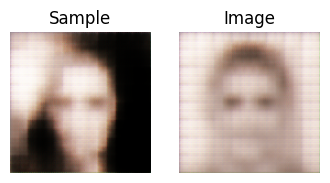

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - kl_loss: 0.0045 - loss: 0.0312 - reconstruction_loss: 0.0308
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0036 - loss: 0.0303 - reconstruction_loss: 0.0299
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0036 - loss: 0.0293 - reconstruction_loss: 0.0289
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0034 - loss: 0.0283 - reconstruction_loss: 0.0279
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0030 - loss: 0.0267 - reconstruction_loss: 0.0264
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0274 - reconstruction_loss: 0.0270
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0029 - loss: 0.0251 - reconstruction_loss: 0.0248
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0241 - reconstruction_loss: 0.0239
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0026 - loss: 0.0227

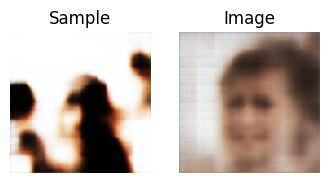

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - kl_loss: 0.0025 - loss: 0.0217 - reconstruction_loss: 0.0215
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0024 - loss: 0.0213 - reconstruction_loss: 0.0210
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0026 - loss: 0.0200 - reconstruction_loss: 0.0198
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0027 - loss: 0.0200 - reconstruction_loss: 0.0198
Epoch 24/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0195 - reconstruction_loss: 0.0192
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0027 - loss: 0.0189 - reconstruction_loss: 0.0186
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0026 - loss: 0.0182 - reconstruction_loss: 0.0179
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0180 - reconstruction_loss: 0.0177
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0026 - loss: 0.0183

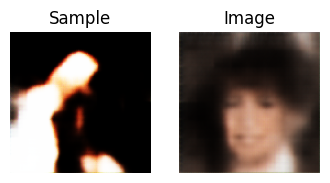

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - kl_loss: 0.0027 - loss: 0.0169 - reconstruction_loss: 0.0167
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0181 - reconstruction_loss: 0.0178
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0171 - reconstruction_loss: 0.0167
Epoch 33/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0170 - reconstruction_loss: 0.0167
Epoch 34/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0158 - reconstruction_loss: 0.0155
Epoch 35/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0029 - loss: 0.0155 - reconstruction_loss: 0.0153
Epoch 36/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0030 - loss: 0.0150 - reconstruction_loss: 0.0147
Epoch 37/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0145 - reconstruction_loss: 0.0142
Epoch 38/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0029 - loss: 0.0149

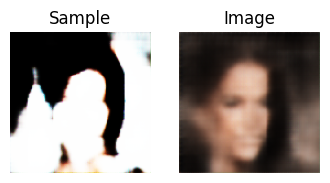

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - kl_loss: 0.0028 - loss: 0.0140 - reconstruction_loss: 0.0137
Epoch 41/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0028 - loss: 0.0146 - reconstruction_loss: 0.0143
Epoch 42/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0030 - loss: 0.0143 - reconstruction_loss: 0.0140
Epoch 43/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0146 - reconstruction_loss: 0.0143
Epoch 44/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0032 - loss: 0.0141 - reconstruction_loss: 0.0138
Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0138 - reconstruction_loss: 0.0135
Epoch 46/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0033 - loss: 0.0134 - reconstruction_loss: 0.0131
Epoch 47/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0126 - reconstruction_loss: 0.0122
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0032 - loss: 0.0127

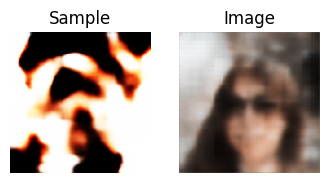

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - kl_loss: 0.0033 - loss: 0.0124 - reconstruction_loss: 0.0120
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0119 - reconstruction_loss: 0.0116
Epoch 52/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0030 - loss: 0.0116 - reconstruction_loss: 0.0113
Epoch 53/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0119 - reconstruction_loss: 0.0115
Epoch 54/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0111 - reconstruction_loss: 0.0108
Epoch 55/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0115 - reconstruction_loss: 0.0112
Epoch 56/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0110 - reconstruction_loss: 0.0107
Epoch 57/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0031 - loss: 0.0110 - reconstruction_loss: 0.0107
Epoch 58/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0032 - loss: 0.0110

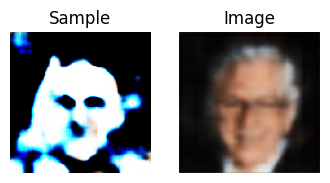

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - kl_loss: 0.0034 - loss: 0.0116 - reconstruction_loss: 0.0113
Epoch 61/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0109 - reconstruction_loss: 0.0105
Epoch 62/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0033 - loss: 0.0111 - reconstruction_loss: 0.0108
Epoch 63/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0035 - loss: 0.0101 - reconstruction_loss: 0.0098
Epoch 64/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - kl_loss: 0.0033 - loss: 0.0098 - reconstruction_loss: 0.0095
Epoch 65/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0033 - loss: 0.0097 - reconstruction_loss: 0.0094
Epoch 66/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0033 - loss: 0.0099 - reconstruction_loss: 0.0095
Epoch 67/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0093 - reconstruction_loss: 0.0090
Epoch 68/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0092

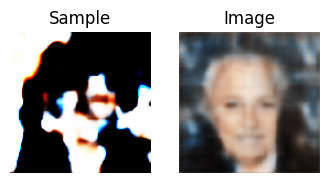

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - kl_loss: 0.0032 - loss: 0.0088 - reconstruction_loss: 0.0085
Epoch 71/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0086 - reconstruction_loss: 0.0083
Epoch 72/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0086 - reconstruction_loss: 0.0083
Epoch 73/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0083 - reconstruction_loss: 0.0080
Epoch 74/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0083 - reconstruction_loss: 0.0080
Epoch 75/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0029 - loss: 0.0079 - reconstruction_loss: 0.0076
Epoch 76/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0081 - reconstruction_loss: 0.0078
Epoch 77/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0029 - loss: 0.0080 - reconstruction_loss: 0.0077
Epoch 78/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0080

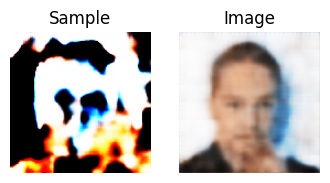

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - kl_loss: 0.0030 - loss: 0.0088 - reconstruction_loss: 0.0085
Epoch 81/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0029 - loss: 0.0088 - reconstruction_loss: 0.0085
Epoch 82/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0096 - reconstruction_loss: 0.0093
Epoch 83/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0034 - loss: 0.0093 - reconstruction_loss: 0.0090
Epoch 84/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0033 - loss: 0.0082 - reconstruction_loss: 0.0079
Epoch 85/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0085 - reconstruction_loss: 0.0082
Epoch 86/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - kl_loss: 0.0032 - loss: 0.0080 - reconstruction_loss: 0.0077
Epoch 87/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0032 - loss: 0.0077 - reconstruction_loss: 0.0074
Epoch 88/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0031 - loss: 0.0075

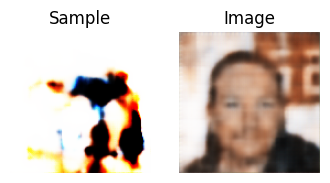

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - kl_loss: 0.0030 - loss: 0.0069 - reconstruction_loss: 0.0066
Epoch 91/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0030 - loss: 0.0068 - reconstruction_loss: 0.0065
Epoch 92/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0028 - loss: 0.0066 - reconstruction_loss: 0.0063
Epoch 93/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0029 - loss: 0.0065 - reconstruction_loss: 0.0062
Epoch 94/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0027 - loss: 0.0062 - reconstruction_loss: 0.0060
Epoch 95/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0028 - loss: 0.0065 - reconstruction_loss: 0.0062
Epoch 96/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0027 - loss: 0.0066 - reconstruction_loss: 0.0064
Epoch 97/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0027 - loss: 0.0064 - reconstruction_loss: 0.0061
Epoch 98/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 0.0027 - loss: 0.0062

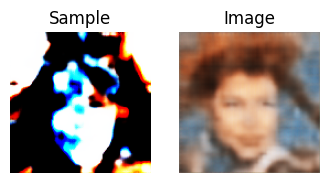

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - kl_loss: 0.0027 - loss: 0.0066 - reconstruction_loss: 0.0063


In [ ]:
# Create CVAE model
cvae = CVAE(encoder, decoder, variational=True)

# Initialise callbacks
history_callback = LossHistoryCallback() # To save the loss
gen_callback = GenerateImageCallback(encoder, decoder, latent_dim=latent_dim, epoch_interval=10) # To see the quality of the imaes we generate at every 10 epochs

# Model compiling and training
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_train, epochs=100, batch_size=32, callbacks=[history_callback, gen_callback])

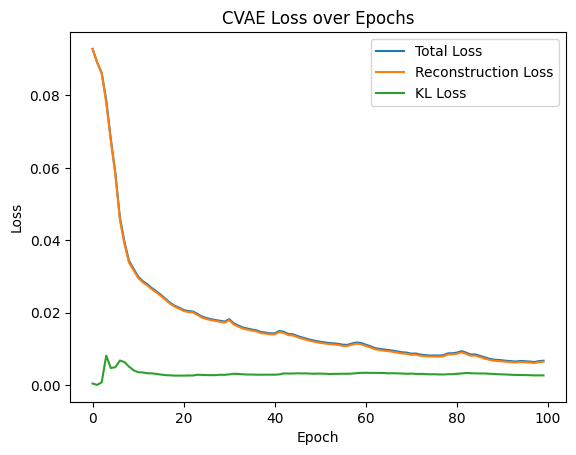

In [ ]:
# Plot the loss as graphic
# import matplotlib.pyplot as plt

plt.plot(total_loss_history, label="Total Loss")
plt.plot(reconstruction_loss_history, label="Reconstruction Loss")
plt.plot(kl_loss_history, label="KL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CVAE Loss over Epochs")
plt.show()

total loss, reconstruction loss et KL loss convergent rapidement et sont stables.

In [ ]:
# Save the model for future usage (encoder, decoder)
encoder.save_weights("encoder.weights.h5")
decoder.save_weights("decoder.weights.h5")

In [ ]:
# Build 2 new encoder/decoder
enc = build_encoder(input_shape=(128,128,3))
dec = build_decoder(output_shape=(128,128,3))

# Add weights to the models
enc.load_weights("encoder.weights.h5")
dec.load_weights("decoder.weights.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


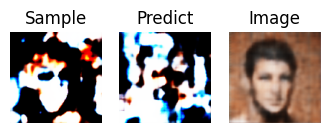

In [ ]:
# Unit test for model loading
z_sample = tf.random.normal(shape=(1, latent_dim))
img = data[random.randint(1,500)]
img = tf.expand_dims(img, axis=0)
z_img, _, _ = enc([img], training=False)
predict = tf.random.normal(shape=(1, latent_dim))

generated_sample = dec([z_sample], training=False)
generated_img = dec([z_img], training=False)
pred = dec.predict([predict])

sample_np = generated_sample[0].numpy()
img_np = generated_img[0].numpy()

plt.figure(figsize=(4, 2))
plt.subplot(1, 3, 1)
plt.title("Sample")
plt.imshow(sample_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predict")
plt.imshow(pred[0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Image")
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
z_mean, _, _, _ = encoder.predict([x_test, y_test], batch_size=32)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step


In [ ]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN : {np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN : 0 / 200


In [ ]:
print(z_mean[:1])

[[ 2.31305677e-02 -2.77237557e-02  2.21105948e-01 -8.47629085e-02
  -5.19177616e-02 -8.70067626e-04 -3.65202455e-03 -4.72174399e-03
   6.09166734e-03  1.60142928e-02 -1.40244905e-02 -7.51899229e-03
   3.16813998e-02 -2.15886999e-03 -1.42174177e-02 -1.21892795e-01
   7.38543049e-02 -3.29628028e-02  6.73577785e-02 -1.52260028e-02
   7.56434277e-02  7.80612886e-01  2.69622449e-02  4.54478003e-02
  -1.45333167e-02 -1.50701180e-01 -3.25042047e-02  1.07857013e+00
   1.00006815e-04  2.44171247e-02 -5.27649894e-02 -5.96331917e-02]]


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


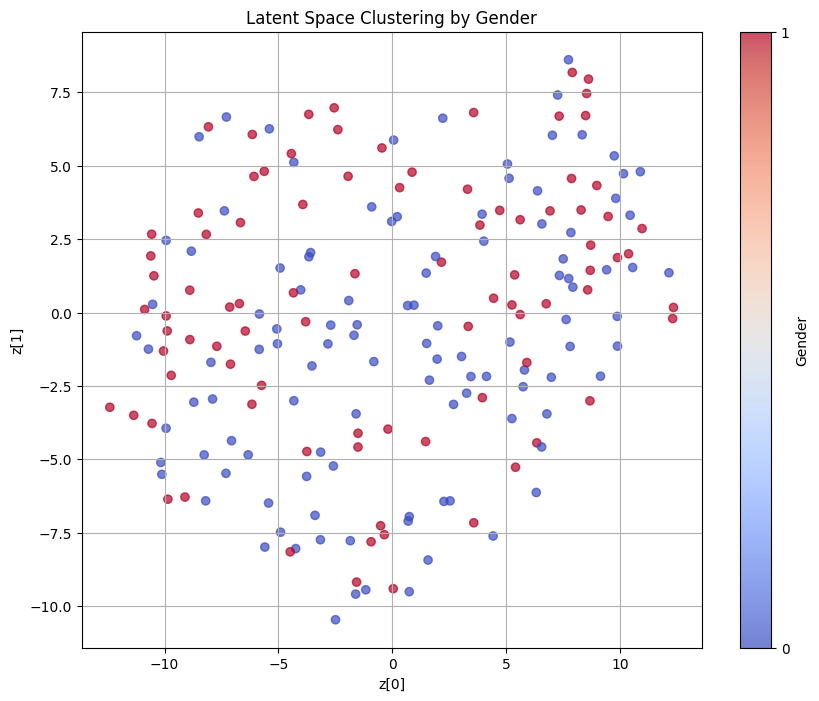

In [ ]:
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


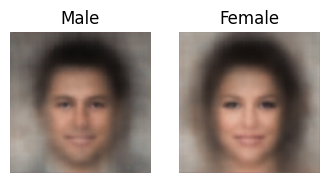

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = decoder.predict([z_sample, label_male])
img_female = decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()